In [1]:
import os
import numpy as np
from functools import partial
import math
from tqdm import tqdm
import time as time

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="2"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.io as sio
from astropy.io import fits
import skimage as ski

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg


True
1
0
NVIDIA A100-PCIE-40GB
Using device: cuda


In [2]:
# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 4999, "record_iters": False}
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
base_savedir = '/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/CRR'
save_dir = base_savedir + '/vars/'
savefig_dir = base_savedir + '/figs/'

# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
# CRR parameters
reg_params = [5e4]
mu = 20


In [3]:
img_name = 'M31'

In [4]:
# %%
# Load image and mask
img, mat_mask = luq.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(
    np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape
)

phi = luq.operators.MaskedFourier_torch(
    shape=img.shape, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)


# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))


# %%
# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
f = luq.operators.RealProx_torch()


# %%
# Load CRR model
torch.set_grad_enabled(False)
torch.set_num_threads(4)

exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(CRR_dir_name + exp_name, 'cuda:0', device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

# L_CRR = model.L.detach().cpu().squeeze().numpy()
# print(f"Lipschitz bound {L_CRR:.3f}")

# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")


INSTRUME                                                                         [astropy.io.fits.card]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 0.770


In [5]:

# %
for it_1 in range(len(reg_params)):

    # Prior parameters
    lmbd = reg_params[it_1]

    # Compute stepsize
    alpha = 0.98 / (g.beta + mu * lmbd * L_CRR)

    # initialization
    x_hat = torch.clone(x_init)
    z = torch.clone(x_init)
    t = 1

    for it_2 in range(options['iter']):
        x_hat_old = torch.clone(x_hat)
        # grad = g.grad(z.squeeze()) +  lmbd * model(mu * z)
        x_hat = z - alpha *(
            g.grad(z) + lmbd * model(mu * z)
        )
        # Reality constraint
        x_hat = f.prox(x_hat)
        
        t_old = t 
        t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
        z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

        # relative change of norm for terminating
        res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()

        if res < options['tol']:
            print("[GD] converged in %d iterations"%(it_2))
            break

        if it_2 % options['update_iter'] == 0:
            print(
                "[GD] %d out of %d iterations, tol = %f" %(            
                    it_2,
                    options['iter'],
                    res,
                )
            )





[GD] 0 out of 15000 iterations, tol = 0.074123
[GD] converged in 1032 iterations


In [20]:
np_x_hat = to_numpy(x_hat)
np_x = np.copy(x)

In [21]:

print('PSNR: ', psnr(np_x, np_x_hat, data_range=np_x.max()-np_x.min()))
print('SNR: ', luq.utils.eval_snr(x, np_x_hat))


PSNR:  55.26012435469741
SNR:  32.82


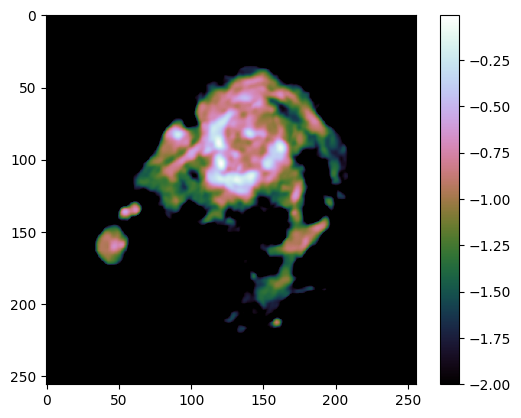

In [25]:
plt.figure()
plt.imshow(np.log10(abs(np_x_hat)), cmap='cubehelix', vmin=-2)
plt.colorbar()
plt.show()


In [9]:

class CRRProx:
    def __init__(self, model, lmbd, mu):
        self.model = model
        self.lmbd = lmbd
        self.mu = mu

    def fun(self, x):
        return 0

    def prox(self, x, tau):
        return torch.clone(x) - tau * self.lmbd * self.model(self.mu * x)

    def dir_op(self, x):
        return x

    def adj_op(self, x):
        return x




In [10]:
h = CRRProx(model, lmbd, mu)


In [11]:



# Run the optimisation
x_hat_FB, diagnostics = luq.optim.FB_torch(
    x_init,
    options=options,
    g=g,
    f=f,
    h=h,
    alpha=alpha,
    tau=alpha,
    viewer=None
)


Running Base Forward Backward
[Forward Backward] 0 out of 15000 iterations, tol = 7.41e-02
[Forward Backward] converged in 3258 iterations


In [12]:
np_x_hat_FB = to_numpy(x_hat_FB)

In [22]:
print('PSNR: ', psnr(np_x, np_x_hat_FB, data_range=np_x.max()-np_x.min()))
print('SNR: ', luq.utils.eval_snr(x, np_x_hat_FB))

PSNR:  55.05019807088065
SNR:  32.61


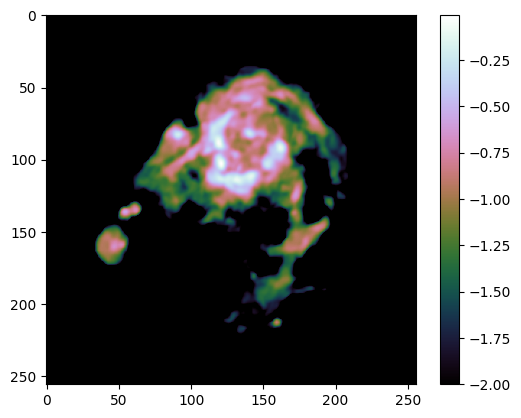

In [26]:
plt.figure()
plt.imshow(np.log10(abs(np_x_hat_FB)), cmap='cubehelix', vmin=-2)
plt.colorbar()
plt.show()

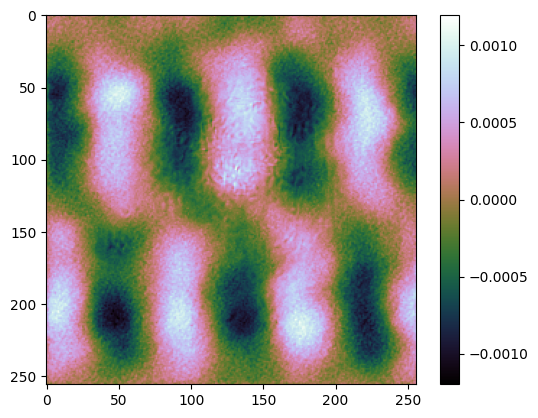

In [14]:

plt.figure()
plt.imshow(np_x_hat - np_x_hat_FB, cmap='cubehelix')
plt.colorbar()
plt.show()
